Quick own project to see if the hydraulic electricity production in Spain can be predicted directly from the water level in the reservoirs. Just for the sake of curiosity. We try regression models.

In [1]:
# Import libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Dataset cleaning

The dataframe used was downloaded from https://www.ree.es/es/datos/publicaciones/series-estadisticas-nacionales

In [2]:
# Get the dataset
filename = "9_Datos_hidraulicos_07_2022.csv"
df = pd.read_csv(filename, encoding='iso-8859-1', on_bad_lines='skip', header=None, sep=";", thousands=".", decimal=",")

# First cleaning step of the dataset
df.drop([0], axis=0, inplace=True) # Drop first row
df.drop(df.iloc[:,425:], axis=1, inplace=True) # Drop end columns
df.drop([0], axis=1, inplace=True) # Drop first column
df = df.T # Transpose
df.drop(df.iloc[:,29:], axis=1, inplace=True) # Drop the unused rows (now columns after transposing)
df.dropna(axis=1, how='all', inplace=True) # Drop columns with all NaN
df.head(-40) # Check

,1,2,3,4,6,7,8,9,11,12,...,18,19,21,22,23,24,26,27,28,29
1,Producible hidráulico mensual peninsular (GWh),Producible hidraulico (GWh),Índice de producible,Probabilidad de ser superado (%),Reservas hidroeléctricas mensuales (GWh),Reservas embalses anuales (GWh),Reservas embalses hiperanuales (GWh),Total reservas (GWh),Reservas hidroeléctricas mensuales (%),Llenado embalses anuales (%),...,Índice de producible,Probabilidad de ser superado (%),Reservas hidroeléctricas anuales peninsulares ...,Reservas embalses anuales (GWh),Reservas embalses hiperanuales (GWh),Total reservas (GWh),Reservas hidroeléctricas anuales peninsulares (%),Llenado embalses anuales (%),Llenado embalses hiperanuales (%),Llenado total reservas (%)
2,ene-90,-,-,-,ene-90,4.519,4.805,9.324,ene-90,"56,2",...,-,-,1990,2.536,2.939,5.475,1990,"31,5","29,4","30,4"
3,feb-90,-,-,-,feb-90,4.413,5.002,9.414,feb-90,"54,9",...,"0,98","49,05",1991,2.332,2.821,5.153,1991,"29,0","28,2","28,6"
4,mar-90,-,-,-,mar-90,3.867,4.590,8.457,mar-90,"48,1",...,"0,74","82,73",1992,3.358,3.693,7.051,1992,"41,1","36,8","38,7"
5,abr-90,-,-,-,abr-90,4.115,4.529,8.644,abr-90,"51,2",...,"0,88","64,00",1993,4.073,3.283,7.356,1993,"49,8","32,1","39,9"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,feb-19,3.278,"0,98","45,84",jul-21,4.642,4.103,8.745,jul-21,"51,8",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381,mar-19,2.258,"0,55","86,57",ago-21,3.722,3.403,7.125,ago-21,"41,5",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382,abr-19,2.475,"0,64","90,94",sep-21,3.327,2.987,6.314,sep-21,"37,1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383,may-19,2.276,"0,69","89,09",oct-21,3.215,2.738,5.953,oct-21,"35,9",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.iloc[0,:].reset_index().drop(["index"], axis=1) # Real column names

,1
0,Producible hidráulico mensual peninsular (GWh)
1,Producible hidraulico (GWh)
2,Índice de producible
3,Probabilidad de ser superado (%)
4,Reservas hidroeléctricas mensuales (GWh)
5,Reservas embalses anuales (GWh)
6,Reservas embalses hiperanuales (GWh)
7,Total reservas (GWh)
8,Reservas hidroeléctricas mensuales (%)
9,Llenado embalses anuales (%)


In [4]:
# Drop the first row (there are repeated names, also be careful with the indices)
df_unnamed = df.drop([1], axis=0)

# Reset the column and row indices to start at 0
df_unnamed = df_unnamed.reset_index().drop(["index"], axis=1)
df_unnamed.columns = range(df_unnamed.columns.size)
df_unnamed.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,ene-90,-,-,-,ene-90,4.519,4.805,9.324,ene-90,"56,2",...,-,-,1990,2.536,2.939,5.475,1990,"31,5","29,4","30,4"
1,feb-90,-,-,-,feb-90,4.413,5.002,9.414,feb-90,"54,9",...,"0,98","49,05",1991,2.332,2.821,5.153,1991,"29,0","28,2","28,6"
2,mar-90,-,-,-,mar-90,3.867,4.590,8.457,mar-90,"48,1",...,"0,74","82,73",1992,3.358,3.693,7.051,1992,"41,1","36,8","38,7"
3,abr-90,-,-,-,abr-90,4.115,4.529,8.644,abr-90,"51,2",...,"0,88","64,00",1993,4.073,3.283,7.356,1993,"49,8","32,1","39,9"
4,may-90,-,-,-,may-90,4.237,4.298,8.536,may-90,"52,7",...,"0,96","52,01",1994,3.613,2.614,6.227,1994,"44,3","25,5","33,8"


In [5]:
# Extract every column of interest

names = ["Fechas", "Producible hidráulico (GWh)", "Índice de producible", "Probabilidad de ser superado (%)", 
         "Reservas embalses anuales (GWh)", "Reservas embalses hiperanuales (GWh)", "Total reservas (GWh)",
         "Llenado embalses anuales (%)", "Reservas embalses hiperanuales (%)", "Total reservas (%)"]

fechas = df_unnamed[4][12:-32] # [:-32] to delete NaNs

prod_hid_GWh = df_unnamed[1][13:].drop(np.arange(13+12,df_unnamed[1][13:].size+13, 13)).apply(lambda x: str(x).replace('.', '')).apply(pd.to_numeric) # check
ind_prod = df_unnamed[2][13:].drop(np.arange(13+12,df_unnamed[1][13:].size+13, 13)).apply(lambda x: str(x).replace(',', '.')).apply(pd.to_numeric) # check
prob_sup = df_unnamed[3][13:].drop(np.arange(13+12,df_unnamed[1][13:].size+13, 13)).apply(lambda x: str(x).replace(',', '.')).apply(pd.to_numeric) # check

res_emb_anu_GWh = df_unnamed[5][12:-32].apply(lambda x: x.replace('.', '')).apply(pd.to_numeric)
res_emb_hiperanu_GWh = df_unnamed[6][12:-32].apply(lambda x: x.replace('.', '')).apply(pd.to_numeric)
tot_res_GWh = df_unnamed[7][12:-32].apply(lambda x: x.replace('.', '')).apply(pd.to_numeric)

llen_emb_anu_percent = df_unnamed[9][12:-32].apply(lambda x: x.replace(',', '.')).apply(pd.to_numeric)
res_emb_hiperanu_percent = df_unnamed[10][12:-32].apply(lambda x: x.replace(',', '.')).apply(pd.to_numeric)
tot_res_percent = df_unnamed[11][12:-32].apply(lambda x: x.replace(',', '.')).apply(pd.to_numeric)

In [6]:
# Join the columns into one clean dataframe

series = [fechas, 
          prod_hid_GWh, ind_prod, prob_sup, 
          res_emb_anu_GWh, res_emb_hiperanu_GWh, tot_res_GWh, 
          llen_emb_anu_percent, res_emb_hiperanu_percent, tot_res_percent]

series = [serie.reset_index(drop=True) for serie in series] # https://stackoverflow.com/questions/18062135/combining-two-series-into-a-dataframe-in-pandas

df_clean = pd.concat(series, axis=1)
df_clean.columns= names
df_clean.head()

,Fechas,Producible hidráulico (GWh),Índice de producible,Probabilidad de ser superado (%),Reservas embalses anuales (GWh),Reservas embalses hiperanuales (GWh),Total reservas (GWh),Llenado embalses anuales (%),Reservas embalses hiperanuales (%),Total reservas (%)
0,ene-91,3271,0.89,51.33,3170,3109,6279,39.4,31.1,34.8
1,feb-91,2052,0.73,58.49,3282,3129,6411,40.8,31.3,35.5
2,mar-91,6102,1.98,5.15,4922,3977,8899,61.2,39.8,49.3
3,abr-91,3148,1.10,30.79,4679,4052,8730,58.2,40.5,48.4
4,may-91,2248,0.86,59.58,4405,3879,8284,54.8,38.8,45.9


The dataset has been cleaned.

---
## Dataset analysis

Check the data types

In [7]:
df_clean.dtypes

Fechas                                   object
Producible hidráulico (GWh)               int64
Índice de producible                    float64
Probabilidad de ser superado (%)        float64
Reservas embalses anuales (GWh)           int64
Reservas embalses hiperanuales (GWh)      int64
Total reservas (GWh)                      int64
Llenado embalses anuales (%)            float64
Reservas embalses hiperanuales (%)      float64
Total reservas (%)                      float64
dtype: object

Look for NaN values

In [8]:
print(np.sum(np.isnan(df_clean[names[1:]]))) # Check for NaN values

Producible hidráulico (GWh)             0
Índice de producible                    0
Probabilidad de ser superado (%)        0
Reservas embalses anuales (GWh)         0
Reservas embalses hiperanuales (GWh)    0
Total reservas (GWh)                    0
Llenado embalses anuales (%)            0
Reservas embalses hiperanuales (%)      0
Total reservas (%)                      0
dtype: int64


Now we will look for correlations.

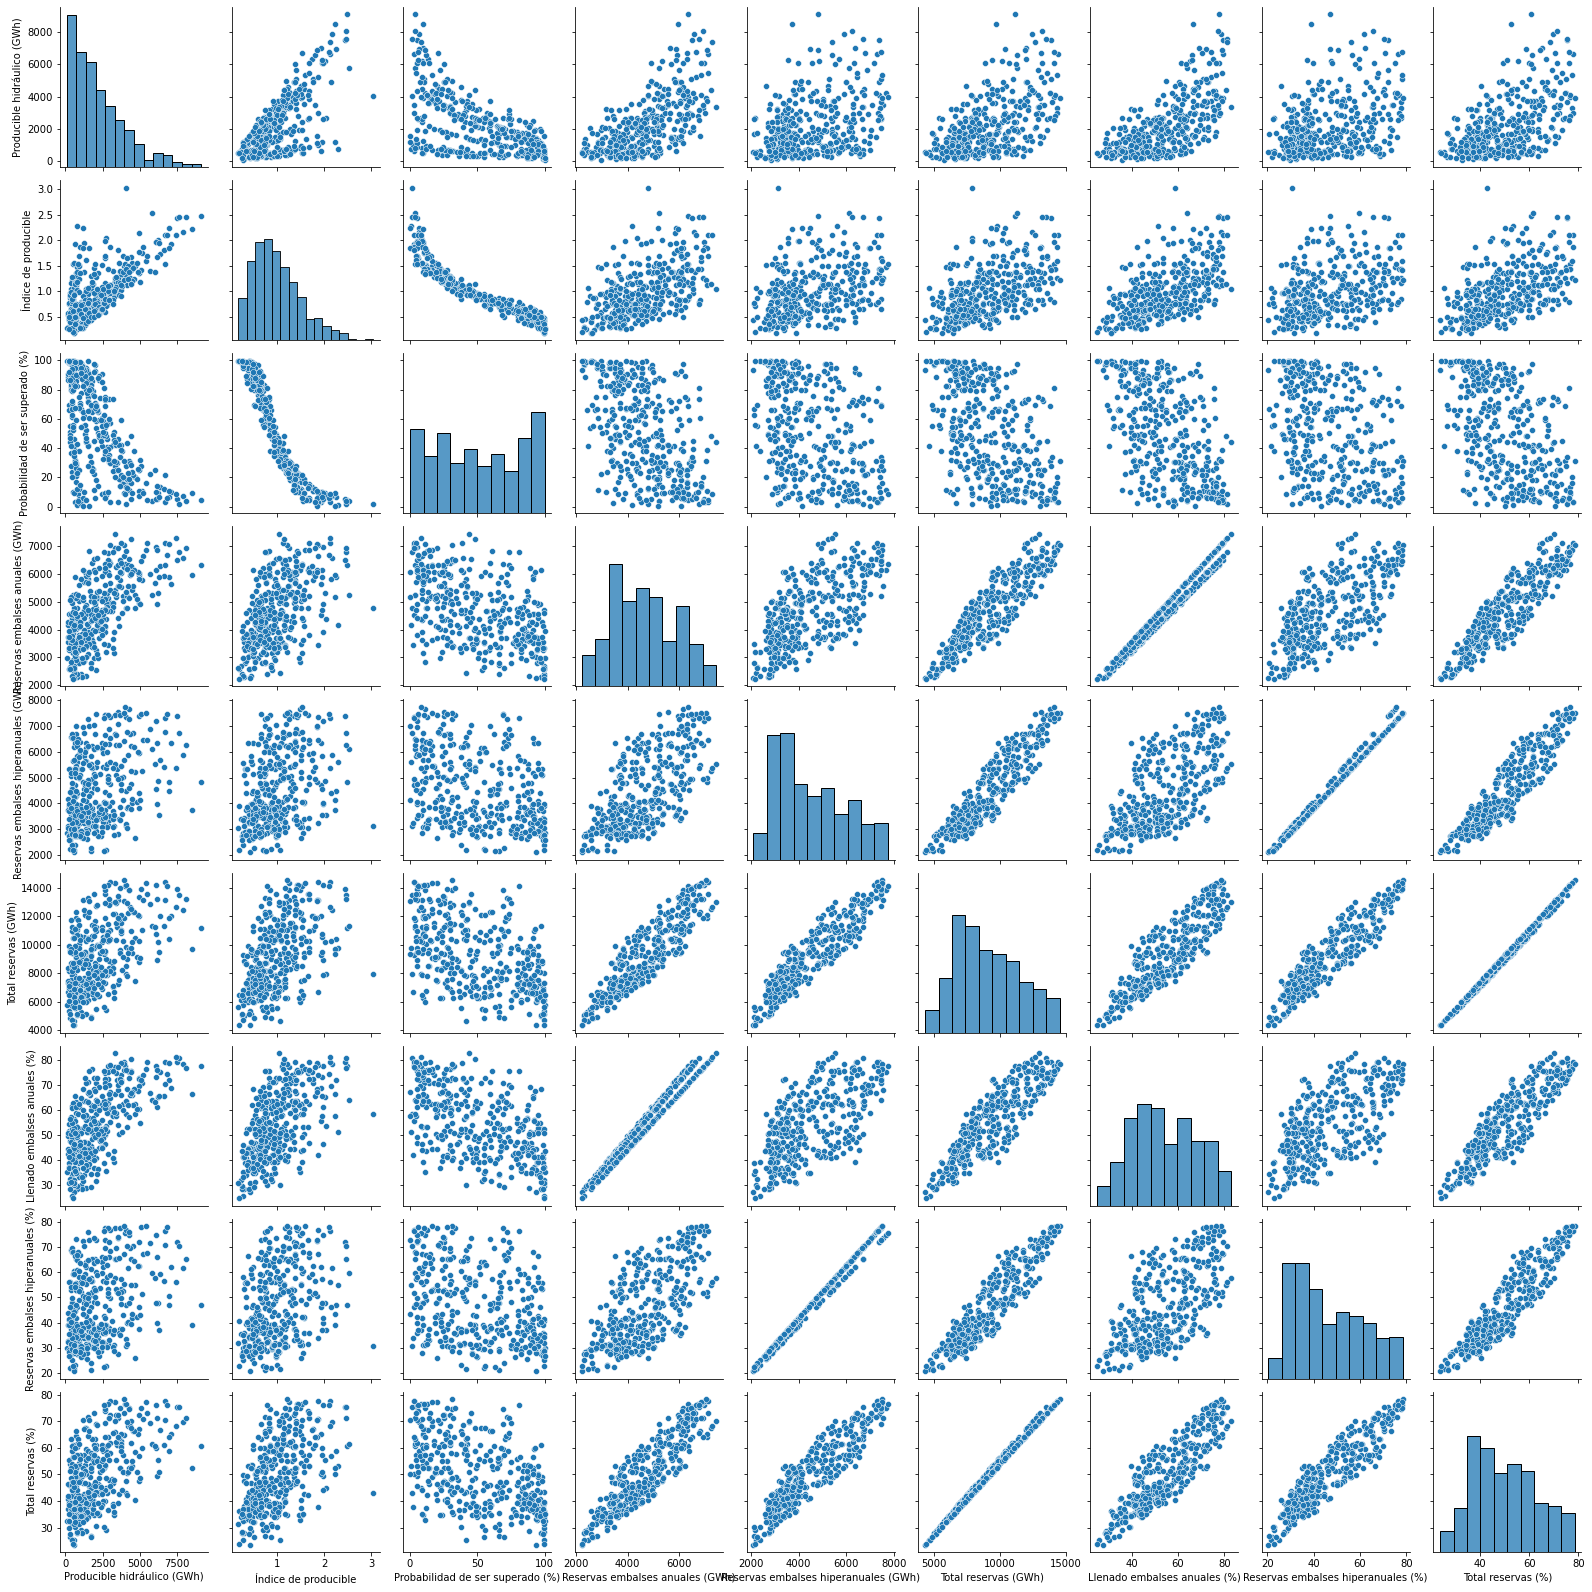

In [9]:
sns.pairplot(df_clean)

In [10]:
df_clean.corr()

,Producible hidráulico (GWh),Índice de producible,Probabilidad de ser superado (%),Reservas embalses anuales (GWh),Reservas embalses hiperanuales (GWh),Total reservas (GWh),Llenado embalses anuales (%),Reservas embalses hiperanuales (%),Total reservas (%)
Producible hidráulico (GWh),1.000000,0.679499,-0.583936,0.664504,0.376140,0.556153,0.673139,0.370536,0.556022
Índice de producible,0.679499,1.000000,-0.924471,0.551643,0.393717,0.509953,0.582935,0.374982,0.511991
Probabilidad de ser superado (%),-0.583936,-0.924471,1.000000,-0.527584,-0.397780,-0.500291,-0.562627,-0.378679,-0.503517
Reservas embalses anuales (GWh),0.664504,0.551643,-0.527584,1.000000,0.668990,0.897911,0.986574,0.673937,0.896628
Reservas embalses hiperanuales (GWh),0.376140,0.393717,-0.397780,0.668990,1.000000,0.927864,0.650757,0.996295,0.925629
Total reservas (GWh),0.556153,0.509953,-0.500291,0.897911,0.927864,1.000000,0.880376,0.928153,0.998033
Llenado embalses anuales (%),0.673139,0.582935,-0.562627,0.986574,0.650757,0.880376,1.000000,0.647738,0.885853
Reservas embalses hiperanuales (%),0.370536,0.374982,-0.378679,0.673937,0.996295,0.928153,0.647738,1.000000,0.927010
Total reservas (%),0.556022,0.511991,-0.503517,0.896628,0.925629,0.998033,0.885853,0.927010,1.000000


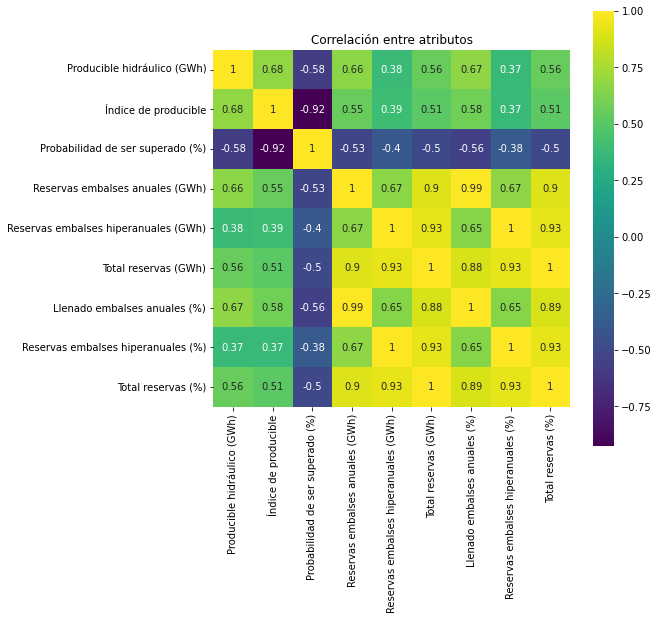

In [11]:
correlation = df_clean.corr()
plt.figure(figsize=(8,8))
ax = sns.heatmap(correlation, vmax=1, square=True, annot = True, cmap = 'viridis')
plt.title('Correlación entre atributos')
plt.show()

We want to predict "Producible hidráulico (GWh)". To do so, we choose "Llenado embalses anuales (%)".

## Training

We will start by selecting the data for the training. We use half of the data (corresponding to the first half of the set of dates), the other half will represent the future data yet to be known.

In [12]:
X, Y = llen_emb_anu_percent.values.T, prod_hid_GWh.values.astype(float).T
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X[:len(X)//2], Y[:len(Y)//2], test_size=0.2, random_state=seed) 

# .reshape(-1,1) to avoid cross_val_score internal errors 
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)

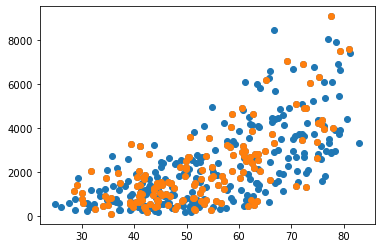

In [13]:
# Visualize the training data (in orange)
plt.scatter(X, Y)
plt.scatter(X_train, Y_train)

We start by testing some simple models.

In [14]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'neg_mean_absolute_error'

# Spot Check Algorithms
models = []
models.append(('LiR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('k-NN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

In [15]:
results = []
modnames = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train.reshape(-1,1), Y_train.reshape(-1,1), cv=kfold, scoring=scoring, error_score="raise")
    results.append(cv_results)
    modnames.append(name)
    print(f"{name}: {cv_results.mean():,.3f} ({cv_results.std():,.3f})")
    #print(cv_results)

LiR: -937.656 (234.676)
LASSO: -937.647 (234.681)
EN: -937.193 (234.892)
k-NN: -867.248 (205.974)
CART: -1,160.232 (195.388)
SVM: -1,212.434 (399.222)


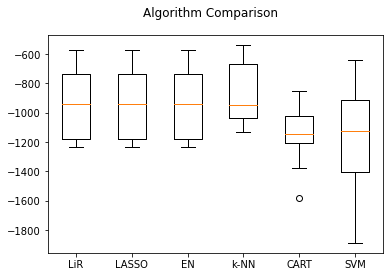

In [16]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(modnames)
plt.show()

Now we check if there is any improvement with data standardization.

In [17]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLiR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('Scaledk-NN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
modnames = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds)#, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring, error_score="raise")
    results.append(cv_results)
    modnames.append(name)
    print(f"{name}: {cv_results.mean():,.3f} ({cv_results.std():,.3f})")

ScaledLiR: -937.656 (234.676)
ScaledLASSO: -937.544 (234.740)
ScaledEN: -956.862 (266.394)
Scaledk-NN: -868.813 (205.083)
ScaledCART: -1,178.012 (228.301)
ScaledSVM: -1,212.434 (399.222)


It does not seem worthwile to scale. We will do a parameter search with K-NN.

In [18]:
n_neighbors = np.arange(1, 91+1, 2) # must be an odd number
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
param_grid = dict(n_neighbors=n_neighbors, algorithm=algorithm)
model = KNeighborsRegressor()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, Y)

print(f"Best neg_mean_absolute_error: {grid.best_score_.mean()}")
print(f"Num neighbors for best accuracy: {grid.best_estimator_.n_neighbors}")
print(f"Algorithm for best accuracy: {grid.best_estimator_.algorithm}")

Best neg_mean_absolute_error: -979.4565695634435
Num neighbors for best accuracy: 43
Algorithm for best accuracy: brute


Now we also test bagging and boosting methods.

In [19]:
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))
results = []
modnames = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)#, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    modnames.append(name)
    print(f"{name}: {cv_results.mean():,.2f} ({cv_results.std():,.2f})")

ScaledAB: -990.09 (208.60)
ScaledGBM: -984.45 (232.86)
ScaledRF: -1,042.81 (211.33)
ScaledET: -1,099.27 (194.82)


In [20]:
# Grid search with scaled GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
model = GradientBoostingRegressor(random_state=seed) # Test different algorithms
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

In [21]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{param}: {mean:,.3f} ({stdev:,.3f})")

Best: -938.995839 using {'n_estimators': 50}
{'n_estimators': 50}: -938.996 (239.950)
{'n_estimators': 100}: -990.750 (233.716)
{'n_estimators': 150}: -1,041.140 (239.778)
{'n_estimators': 200}: -1,073.485 (244.213)
{'n_estimators': 250}: -1,099.679 (249.265)
{'n_estimators': 300}: -1,120.218 (245.140)
{'n_estimators': 350}: -1,133.057 (245.426)
{'n_estimators': 400}: -1,144.163 (242.917)


Seems that GBR using 50 estimators is best than K-NN.

## Predictions

Finally, we use the chosen model for future value prediction.

In [22]:
# prepare the model.
model = GradientBoostingRegressor(n_estimators=50, random_state=seed)
#model = KNeighborsRegressor(n_neighbors=43, algorithm="brute")
model.fit(X_train, Y_train)

GradientBoostingRegressor(n_estimators=50, random_state=7)

In [23]:
# Test the predictions.
predictions = model.predict(X_test)
print(mean_squared_error(Y_test, predictions))
print(predictions)

2882770.205283065
[1243.20391956 1155.18729029 1133.7992078  3884.03323055 1137.1372529
 3182.42933638 3767.55655988 1650.31416781 3182.42933638 1133.7992078
 1248.59056202 2424.69883746 8322.96352086 1213.69068334  907.27966529
 3767.55655988 1046.60729029 1213.69068334  922.75442509 3490.63996335
 1046.60729029 2785.08730295 5566.01274545 4400.43440963  949.94603797
 1133.7992078  2561.14673081 1588.40901609 4218.17623055 1243.20391956
 2561.14673081 3767.55655988 4681.33639682 1133.7992078  7250.70342768
 1133.7992078  1046.60729029 1133.7992078 ]


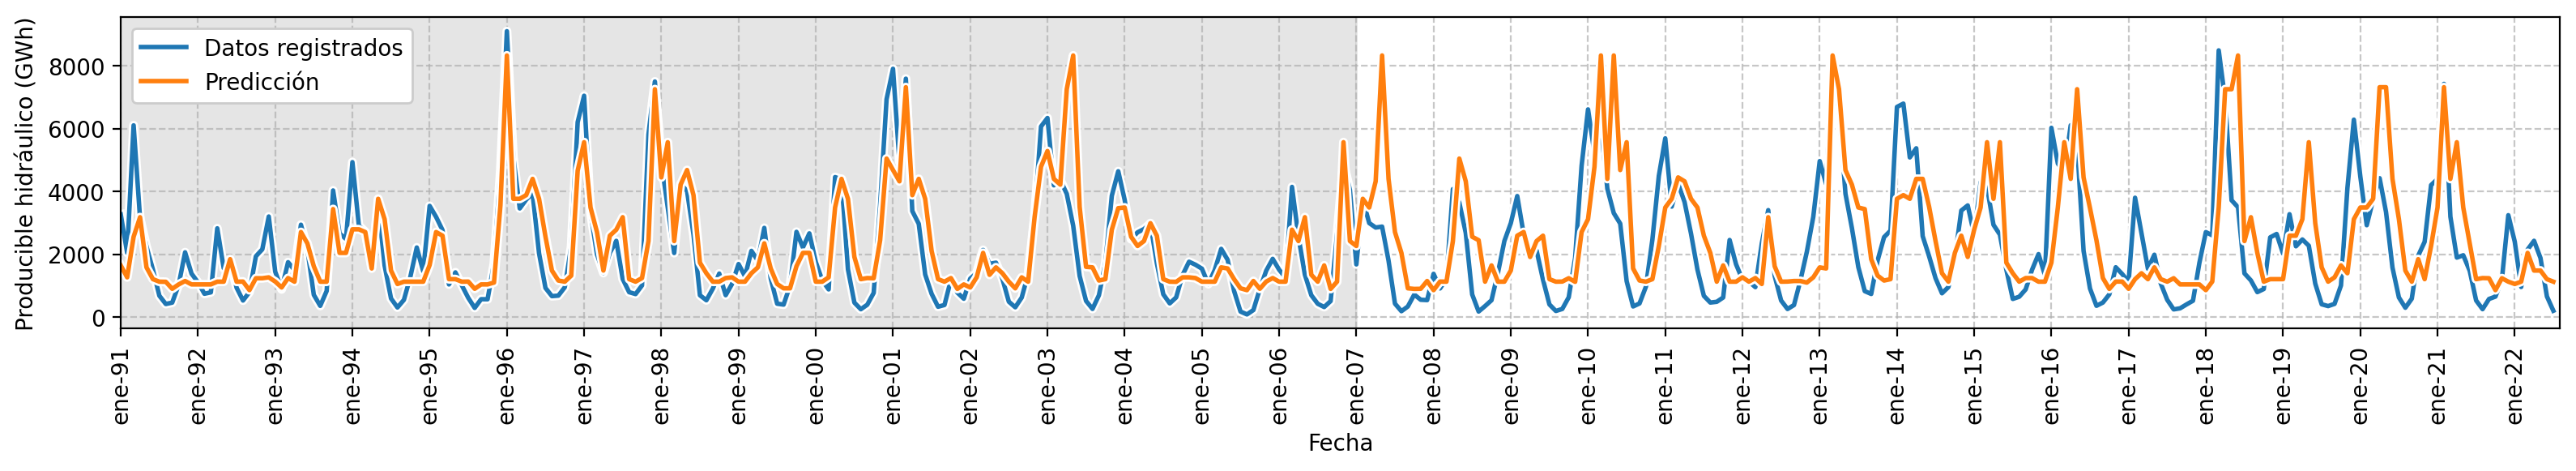

In [25]:
# Visualize the data.
fig, ax = plt.subplots(figsize=(16,3), dpi=200)

lw=2
a=1

xaxis = np.arange(0, fechas.size)

ax.plot(xaxis, prod_hid_GWh, lw=lw*2, c="w")
ax.plot(xaxis, prod_hid_GWh, lw=lw, c="C0", alpha=a, label="Datos registrados")

ax.plot(xaxis, model.predict(llen_emb_anu_percent.values.T.reshape(-1,1)), lw=lw*2, c="w")
ax.plot(xaxis, model.predict(llen_emb_anu_percent.values.T.reshape(-1,1)), lw=lw, c="C1", alpha=a, label="Predicción")
ax.set_xlabel("Fecha")
ax.set_ylabel("Producible hidráulico (GWh)")

xaxisticks = np.arange(0, fechas.size, 12)
ax.set_xticks(xaxisticks)
ax.set_xticklabels(fechas[np.arange(12, fechas.size+12, 12)], rotation=90)
ax.grid(ls="--", zorder=0, alpha=0.7)

xlims = ax.get_xlim()
ylims = ax.get_ylim()

#ax.fill_between([xaxisticks[len(xaxisticks)//2], xaxisticks[len(xaxisticks)-1]+200], -1000, 10000, color="lightblue", alpha=0.5)
ax.fill_between([xaxisticks[0]-200, xaxisticks[len(xaxisticks)//2]], -1000, 10000, color="gray", alpha=0.2)

ax.set_xlim((0, fechas.size))
ax.set_ylim(ylims)
ax.legend(loc="best", framealpha=1)
plt.tight_layout()
plt.show()

The gray area in the plot indicates the set of dates (Fechas) from which the training subsets were chosen. The region with white background on the right corresponds to the future predicted values. The real values from the dataset are plotted in blue color, the predicted values are plotted in orange color.

We observe that the model is not very accurate. However it seems to estimate the increase-decrease periods and to give an approximate idea of the curve amplitudes. The predicted baseline is off by about 1000 GWh.

The model does not seem to be very good.